# PPO

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/EVA_MiLab_Hackathon

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/EVA_MiLab_Hackathon
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
!pip install swig
!pip install "gymnasium[box2d]==1.0.0"

In [22]:
import numpy as np
import torch

def reward_shaping(reward, action, next_state):
    """
    Modify rewards to encourage smoother driving.

    Args:
        reward (float): Original environment reward.
        action (np.array): The action taken [steering, gas, brake].
        next_state (np.array): The next state after action.

    Returns:
        float: Modified reward.
    """

    steering, gas, brake = action[0], action[1], action[2]

    # **1. Penalize Extreme Steering (Zig-Zagging)**
    if abs(steering) > 0.8:
        reward -= 0.1  # Reduce reward for large steering values

    # **2. Reward Smooth Acceleration**
    if gas > 0.6 and abs(steering) < 0.3:
        reward += 0.1  # Bonus for accelerating straight

    # **3. Penalize Over-Braking**
    if brake > 0.5:
        reward -= 0.05  # Reduce reward if braking is too high

    # **4. Encourage Staying on the Track**
    # Penalize if the car is off-road
    off_track_penalty = detect_off_track(next_state)
    reward -= off_track_penalty  # Apply penalty if off-track

    return reward


In [23]:
def detect_off_track(next_state):
    """
    Detect if the car is off the road by analyzing pixel values.

    Args:
        next_state (np.array): The next frame after taking an action.

    Returns:
        float: Penalty if the car is off the track.
    """
    # Convert to numpy if tensor
    if isinstance(next_state, torch.Tensor):
        next_state = next_state.cpu().numpy()

    # Extract a region around the car (assuming center-focused camera)
    center_region = next_state[:, 40:56, 40:56]  # Crop middle part of image

    # Calculate average brightness (off-road areas are generally lighter)
    avg_pixel_value = np.mean(center_region)

    # If too bright, likely off the road (penalize more)
    if avg_pixel_value > 0.7:
        return 0.2  # Apply penalty for off-track driving
    return 0.0  # No penalty if on the road


In [24]:
from itertools import count
import matplotlib
import matplotlib.pyplot as plt
from time import gmtime, strftime
import gymnasium as gym
import numpy as np
import torch
from matplotlib import pyplot as plt
from agents.cnn_ppo import CNN_PPO_Agent

def train_agent(episodes, run_name):
    env = gym.make("CarRacing-v3", render_mode="rgb_array", lap_complete_percent=0.95, domain_randomize=False, continuous=True)
    env._max_episode_steps = 1000
    buffer = []
    update_every = 2048  # Update PPO after collecting 2048 transitions

    agent = CNN_PPO_Agent(input_shape=env.observation_space.shape, run_name=run_name)

    for episode in range(episodes):
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=agent.device)
        state = state.permute(2, 0, 1).unsqueeze(0)  # Ensure shape (1, C, H, W)

        total_reward = 0
        done = False
        t = 0

        while not done:
            action, log_prob, value = agent.select_action(state)
            action = np.array(action, dtype=np.float32)

            next_state, reward, done, _, _ = env.step(action)
            reward = reward_shaping(reward, action, next_state)  # Apply reward shaping

            next_state = torch.tensor(next_state, dtype=torch.float32, device=agent.device)
            next_state = next_state.permute(2, 0, 1).unsqueeze(0)  # Ensure shape (1, 3, 96, 96)

            buffer.append((state, action, reward, next_state, log_prob, value, done))

            if len(buffer) >= update_every:
                for transition in buffer:
                    agent.store_transition(transition)
                agent.update()
                buffer = []  # Clear buffer after update

            state = next_state
            total_reward += reward
            t += 1

            if t >= 1000:  # Force episode termination after 1000 steps
                print(f"Episode {episode} reached max steps (1000), terminating.")
                done = True

            if done:
                agent.episode_durations.append(episode + 1)
                plot_durations(agent.episode_durations)

                if episode == episodes - 1:
                    plot_durations(agent.episode_durations, show_result=True, save_path=f"plots/{run_name}_training_plot.png")
                break

        agent._log_reward(episode, total_reward)

        if episode % 50 == 0:
            agent.save_checkpoint(episode)

        print(f"Episode {episode}: Total Reward: {total_reward}")

    env.close()


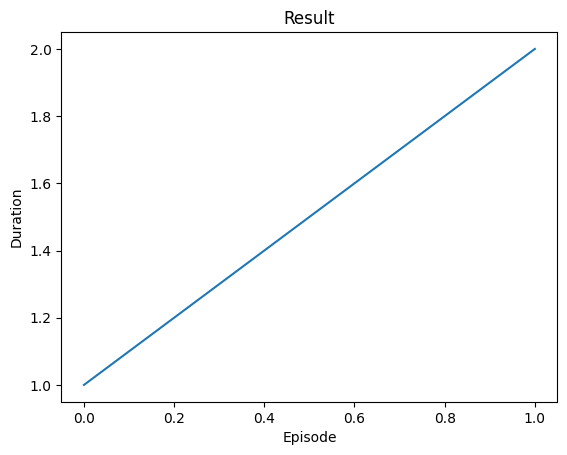

<Figure size 640x480 with 0 Axes>

Plot saved at plots/CNN_PPO_20250211212310_training_plot.png
Episode 1: Total Reward: -112.85410958904195


<Figure size 640x480 with 0 Axes>

In [25]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")


RUN_NAME = f"CNN_PPO_{strftime('%Y%m%d%H%M%S', gmtime())}"
train_agent(episodes = 2, run_name = RUN_NAME)